
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## RBFs reconstruction of historical and synthetic data

inputs required: 
  * Historical offshore waves
  * Synthetic offshore waves - emulator output
  * Sea and swell SWAN simulated  cases from ***Notebook 02_02***

in this notebook:
  * RBF reconstruction historical and simulated storms
  * Generation of hourly nearshore waves with Intradaily Hydrographs
  * Validation: syntethic and historical nearshore waves histograms



### Workflow:

<div>
<img src="resources/nb02_03.png" width="400px">
</div>



In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database, hyswan_db
from teslakit.rbf import RBF_Reconstruction, RBF_Validation
from teslakit.waves import Aggregate_WavesFamilies, AWL, Intradaily_Hydrograph
from teslakit.climate_emulator import Climate_Emulator
from teslakit.util.time_operations import repair_times_hourly, add_max_storms_mask

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


# --------------------------------------
# hyswan databases

# historical
db_hist = hyswan_db(db.paths.site.HYSWAN.hist)

# simulation
db_sim = hyswan_db(db.paths.site.HYSWAN.sim)


In [3]:
# --------------------------------------
# aux.

def fix_target_nans(subset, target):
    'remove NaN data indexes from subset and target. RBF does not handle NaNs'
    
    r_nan = target.isnull().any(axis=1)  # find any row with nans

    if r_nan.any():
        # log
        print('remove nan data found at target:')
        print(target[r_nan])
        
        # clean data
        target = target[~r_nan]
        subset = subset[~r_nan]
        
    return subset, target



## HISTORICAL Waves Reconstruction

In [4]:
# --------------------------------------
# RBF Reconstruction data

# historical sea
wvs_sea_dataset = db_hist.Load('sea_dataset') 
wvs_sea_subset = db_hist.Load('sea_subset') 
wvs_sea_target = db_hist.Load('sea_target') 

# historical swells
wvs_swl_dataset = db_hist.Load('swl_dataset') 
wvs_swl_subset = db_hist.Load('swl_subset') 
wvs_swl_target = db_hist.Load('swl_target') 


# solve Hs coefficient
wvs_sea_target['Hsig'] = wvs_sea_target['Hsig'] * wvs_sea_subset['hs']
wvs_swl_target['Hsig'] = wvs_swl_target['Hsig'] * wvs_swl_subset['hs']


# remove nans (if any) from subset and target
wvs_sea_subset, wvs_sea_target = fix_target_nans(wvs_sea_subset, wvs_sea_target)
wvs_swl_subset, wvs_swl_target = fix_target_nans(wvs_swl_subset, wvs_swl_target)


# ensure dataset and subset have same variables and column order
vns_ds = ['hs', 'tp', 'dir']

wvs_sea_dataset = wvs_sea_dataset[vns_ds].values
wvs_sea_subset = wvs_sea_subset[vns_ds].values

wvs_swl_dataset = wvs_swl_dataset[vns_ds].values
wvs_swl_subset = wvs_swl_subset[vns_ds].values


# select target variables
vns_tgt = ['Hsig', 'TPsmoo', 'Dir']

wvs_sea_target = wvs_sea_target[vns_tgt].values
wvs_swl_target = wvs_swl_target[vns_tgt].values


In [5]:
# --------------------------------------
# RBF Reconstruction library

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo, Dir)
ix_directional_target = [2]   # directional (Dir)


# RBF wrappers 
def RBF_Reconstruction_sea(dataset_input):
    
    return RBF_Reconstruction(
    wvs_sea_subset, ix_scalar_subset, ix_directional_subset,
    wvs_sea_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_swell(dataset_input):
    
    return RBF_Reconstruction(
    wvs_swl_subset, ix_scalar_subset, ix_directional_subset,
    wvs_swl_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_families(data):
   
    # sea
    vs = ['sea_Hs', 'sea_Tp', 'sea_Dir']
    data_sea = data[vs].dropna()
    data_sea.drop(data_sea[(data_sea['sea_Dir'] >= 360)].index, inplace=True)  # fix sea_Dir >> 360 bug    
    rec_sea = RBF_Reconstruction_sea(data_sea.values)
    rec_sea = pd.DataFrame(data=rec_sea, columns=vs, index=data_sea.index)

    # swell 1
    vs = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir']
    data_swl_1 = data[vs].dropna()
    rec_swl_1 = RBF_Reconstruction_swell(data_swl_1.values)
    rec_swl_1 = pd.DataFrame(data=rec_swl_1, columns=vs, index=data_swl_1.index)

    # swell 2
    vs = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir']
    data_swl_2 = data[vs].dropna()
    rec_swl_2 = RBF_Reconstruction_swell(data_swl_2.values)
    rec_swl_2 = pd.DataFrame(data=rec_swl_2, columns=vs, index=data_swl_2.index)
    
    # join nearshore reconstructed data and parse to xarray.Dataset
    rec_waves = pd.concat([rec_sea, rec_swl_1, rec_swl_2], axis=1)

    # return pandas.dataframe
    return rec_waves


In [6]:
# --------------------------------------
# Load historical waves families

WVS = db.Load_WAVES_hist()
WVS = WVS.drop(['Hs', 'Tp', 'Dir', 'TC_category'])

# Reconstruct waves by families
WVS_rec = xr.Dataset.from_dataframe(RBF_Reconstruction_families(WVS.to_dataframe()))

# aggregate nearshore variables (Tp from max. energy waves family)
WVS_a = Aggregate_WavesFamilies(WVS_rec)
WVS_rec = xr.merge([WVS_rec, WVS_a])

# calculate nearshore AWL
WVS_rec['AWL'] = AWL(WVS_rec['Hs'], WVS_rec['Tp'])

# store historical hourly nearshore waves reconstruction
db.Save_HIST_NEARSHORE(WVS_rec)

WVS_HIST_rec = WVS_rec


ix_scalar: 0,  optimization: 0.30 | interpolation: 16.31
ix_scalar: 1,  optimization: 0.76 | interpolation: 13.82
ix_directional: 2,  optimization: 0.88 | interpolation: 28.10
ix_scalar: 0,  optimization: 0.44 | interpolation: 27.61
ix_scalar: 1,  optimization: 5.47 | interpolation: 24.12
ix_directional: 2,  optimization: 0.80 | interpolation: 25.30
ix_scalar: 0,  optimization: 0.44 | interpolation: 12.87
ix_scalar: 1,  optimization: 0.38 | interpolation: 13.10
ix_directional: 2,  optimization: 0.36 | interpolation: 30.45



## SIMULATION Waves Reconstruction

In [7]:
# --------------------------------------
# RBF Reconstruction data

# historical sea
wvs_sea_dataset = db_sim.Load('sea_dataset') 
wvs_sea_subset = db_sim.Load('sea_subset') 
wvs_sea_target = db_sim.Load('sea_target') 

# historical swells
wvs_swl_dataset = db_sim.Load('swl_dataset') 
wvs_swl_subset = db_sim.Load('swl_subset') 
wvs_swl_target = db_sim.Load('swl_target') 


# solve Hs coefficient
wvs_sea_target['Hsig'] = wvs_sea_target['Hsig'] * wvs_sea_subset['hs']
wvs_swl_target['Hsig'] = wvs_swl_target['Hsig'] * wvs_swl_subset['hs']


# remove nans (if any) from subset and target
wvs_sea_subset, wvs_sea_target = fix_target_nans(wvs_sea_subset, wvs_sea_target)
wvs_swl_subset, wvs_swl_target = fix_target_nans(wvs_swl_subset, wvs_swl_target)


# ensure dataset and subset have same variables and column order
vns_ds = ['hs', 'tp', 'dir']

wvs_sea_dataset = wvs_sea_dataset[vns_ds].values
wvs_sea_subset = wvs_sea_subset[vns_ds].values

wvs_swl_dataset = wvs_swl_dataset[vns_ds].values
wvs_swl_subset = wvs_swl_subset[vns_ds].values


# select target variables
vns_tgt = ['Hsig', 'TPsmoo', 'Dir']

wvs_sea_target = wvs_sea_target[vns_tgt].values
wvs_swl_target = wvs_swl_target[vns_tgt].values


remove nan data found at target:
           lon     lat  Hsig  Tm02  Dir  Dspr  TPsmoo
case                                                 
15    167.4679  9.4165   0.0   NaN  NaN   NaN     NaN


In [8]:
# --------------------------------------
# RBF Reconstruction library

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo, Dir)
ix_directional_target = [2]   # directional (Dir)


# RBF wrappers 
def RBF_Reconstruction_sea(dataset_input):
    
    return RBF_Reconstruction(
    wvs_sea_subset, ix_scalar_subset, ix_directional_subset,
    wvs_sea_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_swell(dataset_input):
    
    return RBF_Reconstruction(
    wvs_swl_subset, ix_scalar_subset, ix_directional_subset,
    wvs_swl_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_families(data):
   
    # sea
    vs = ['sea_Hs', 'sea_Tp', 'sea_Dir']
    data_sea = data[vs].dropna()
    data_sea.drop(data_sea[(data_sea['sea_Dir'] >= 360)].index, inplace=True)  # fix sea_Dir >> 360 bug    
    rec_sea = RBF_Reconstruction_sea(data_sea.values)
    rec_sea = pd.DataFrame(data=rec_sea, columns=vs, index=data_sea.index)

    # swell 1
    vs = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir']
    data_swl_1 = data[vs].dropna()
    rec_swl_1 = RBF_Reconstruction_swell(data_swl_1.values)
    rec_swl_1 = pd.DataFrame(data=rec_swl_1, columns=vs, index=data_swl_1.index)

    # swell 2
    vs = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir']
    data_swl_2 = data[vs].dropna()
    rec_swl_2 = RBF_Reconstruction_swell(data_swl_2.values)
    rec_swl_2 = pd.DataFrame(data=rec_swl_2, columns=vs, index=data_swl_2.index)
    
    # join nearshore reconstructed data and parse to xarray.Dataset
    rec_waves = pd.concat([rec_sea, rec_swl_1, rec_swl_2], axis=1)

    # return pandas.dataframe
    return rec_waves


In [10]:
# --------------------------------------
# Load simulation waves families

n_sims_DWTs = 10

CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

WVS = CE.LoadSim_All()

# Reconstruct waves by families
WVS_rec = RBF_Reconstruction_families(WVS)
WVS_rec['n_sim'] = WVS.n_sim
WVS_rec['time'] = WVS.time

WVS_SIM_rec = WVS_rec


ix_scalar: 0,  optimization: 0.39 | interpolation: 55.50
ix_scalar: 1,  optimization: 0.88 | interpolation: 68.24
ix_directional: 2,  optimization: 7.74 | interpolation: 110.08
ix_scalar: 0,  optimization: 0.41 | interpolation: 119.38
ix_scalar: 1,  optimization: 0.52 | interpolation: 105.62
ix_directional: 2,  optimization: 0.26 | interpolation: 179.09
ix_scalar: 0,  optimization: 0.20 | interpolation: 98.98
ix_scalar: 1,  optimization: 0.24 | interpolation: 99.88
ix_directional: 2,  optimization: 0.18 | interpolation: 200.14


In [11]:
def waves_hourly(CE, WVS_SIM_rec, n_sim_ce=0):
    '''
    Generate nearshore hourly simulation output. 
    
    - aggregate nearshore waves storms
    - generate hourly hydrographs
    - calculates AWL
    
    Stores simulation nearshore waves at teslakit site database
    '''
    
    # iterate simulations
    for n in range(n_sims_DWTs):
        
        # select simulation
        WVS_SIM_rec_n = WVS_SIM_rec.loc[WVS_SIM_rec['n_sim'] == n]

        # aggregate nearshore variables (Tp from max. energy waves family)
        wvs_agr = Aggregate_WavesFamilies(WVS_SIM_rec_n)
        
        # Load TCs storm data from climate emulator
        _, TCS_sim, _ = CE.LoadSim(n_sim = n)    
        TCS_sim = TCS_sim.isel(n_sim = n_sim_ce).copy() 
        TCS_sim = TCS_sim.sel(time=wvs_agr.time)
        
        # calculate intradaily hourly hydrographs for simulated storms
        wvs_h = Intradaily_Hydrograph(wvs_agr, TCS_sim)
        
        # calculate AWL
        wvs_h['AWL'] = AWL(wvs_h.Hs, wvs_h.Tp)
        
        # store hourly simulation offshore data
        db.Save_SIM_NEARSHORE(wvs_h, n)
                
        print('simulation {0} processed.'.format(n))

# generate intradaily hydrographs
waves_hourly(CE, WVS_rec)  


simulation 0 processed.
simulation 1 processed.
simulation 2 processed.
simulation 3 processed.
simulation 4 processed.
simulation 5 processed.
simulation 6 processed.
simulation 7 processed.
simulation 8 processed.
simulation 9 processed.



## Methodology Validation: Historical - Simulation Waves Families Comparison

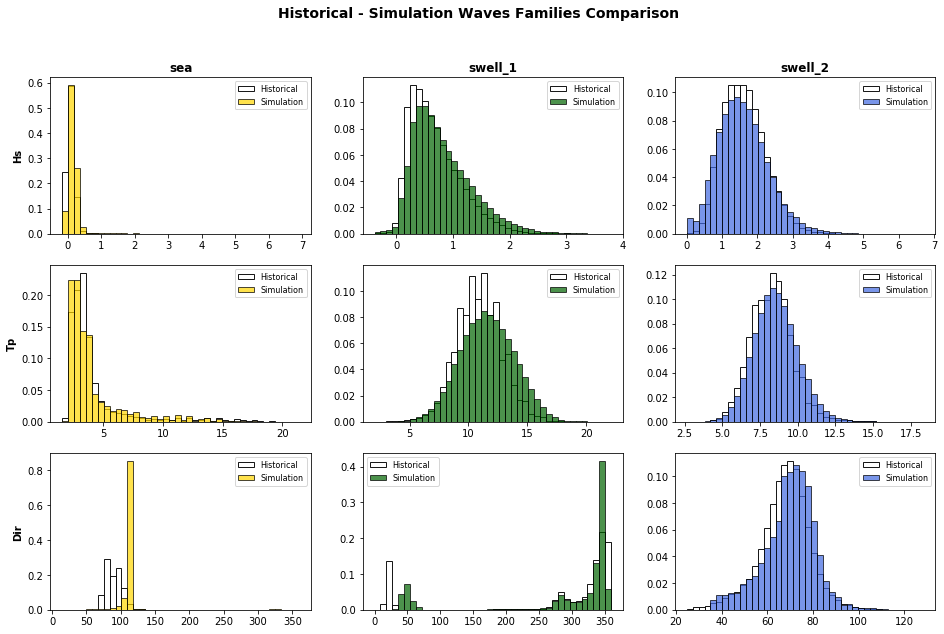

In [12]:
# --------------------------------------
# Compare waves families for reconstructed historical and simulated storms

# get storms from historical reconstruction
#time_storms = HIST_C_h.where(HIST_C_h['max_storms']==True, drop=True).time
#WVS_HIST_rec_s = WVS_HIST_rec.sel(time=time_storms)

# Select Simulation to plot storms
n_sim = 0
WVS_SIM_rec_n_s = WVS_SIM_rec.loc[WVS_SIM_rec['n_sim'] == n_sim]

# Plot reconstructed nearshore waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_HIST_rec, WVS_SIM_rec_n_s);
